In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import process_time
import seaborn as sns

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import ensemble, preprocessing, metrics
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import np_utils
np.random.seed(10)
import csv

In [2]:
SDNdata = pd.read_csv("C:\pythonwork\dataset_sdn.csv")
print(SDNdata.describe())

                  dt         switch       pktcount     bytecount  \
count  104345.000000  104345.000000  104345.000000  1.043450e+05   
mean    17927.514169       4.214260   52860.954746  3.818660e+07   
std     11977.642655       1.956327   52023.241460  4.877748e+07   
min      2488.000000       1.000000       0.000000  0.000000e+00   
25%      7098.000000       3.000000     808.000000  7.957600e+04   
50%     11905.000000       4.000000   42828.000000  6.471930e+06   
75%     29952.000000       5.000000   94796.000000  7.620354e+07   
max     42935.000000      10.000000  260006.000000  1.471280e+08   

                 dur      dur_nsec       tot_dur          flows  \
count  104345.000000  1.043450e+05  1.043450e+05  104345.000000   
mean      321.497398  4.613880e+08  3.218865e+11       5.654234   
std       283.518232  2.770019e+08  2.834029e+11       2.950036   
min         0.000000  0.000000e+00  0.000000e+00       2.000000   
25%       127.000000  2.340000e+08  1.270000e+11    

# 資料前處理

In [3]:
#先把NULL值的資料Drop掉
SDNdata.dropna(inplace=True)
SDNdata.shape

(103839, 23)

In [4]:
fe=SDNdata.groupby('Protocol').size()/len(SDNdata)
SDNdata.loc[:,'Protocol']=SDNdata['Protocol'].map(fe)

In [5]:
fe=SDNdata.groupby('dst').size()/len(SDNdata)
SDNdata.loc[:,'dst']=SDNdata['dst'].map(fe)

In [6]:
fe=SDNdata.groupby('src').size()/len(SDNdata)
SDNdata.loc[:,'src']=SDNdata['src'].map(fe)

In [7]:
#把資料分為屬性和標籤，然後20%測試80%訓練
x = SDNdata.drop('label', axis=1)
y = SDNdata['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20,random_state=100)

In [8]:
#指定陣列
df_x_train =pd.DataFrame(x_train)
df_x_test =pd.DataFrame(x_test)
df_y_train =pd.DataFrame(y_train)
df_y_test =pd.DataFrame(y_test)

In [9]:
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled_x_train=minmax_scale.fit_transform(df_x_train)
scaled_x_test=minmax_scale.fit_transform(df_x_test)
scaled_y_train=minmax_scale.fit_transform(df_y_train)
scaled_y_test=minmax_scale.fit_transform(df_y_test)

In [10]:
scaled_x_train.shape

(83071, 22)

In [11]:
scaled_x_test.shape

(20768, 22)

In [12]:
scaled_y_train.shape

(83071, 1)

In [13]:
scaled_y_test.shape

(20768, 1)

In [14]:
X_train = np.reshape( scaled_x_train, ( scaled_x_train.shape[0], scaled_x_train.shape[1],1,1))
X_test = np.reshape(scaled_x_test, (scaled_x_test.shape[0],scaled_x_test.shape[1],1,1))

In [15]:
X_train.shape

(83071, 22, 1, 1)

In [16]:
X_test.shape

(20768, 22, 1, 1)

# 建立模型

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling1D, ZeroPadding2D, Convolution1D

In [18]:
cnn = Sequential()

In [19]:
cnn.add(Convolution1D(64, 3, padding='same',activation="relu",input_shape=(22, 1)))

In [20]:
cnn.add(Convolution1D(64, 3, padding='same', activation="relu"))

In [21]:
cnn.add(MaxPooling1D(pool_size=1))

In [22]:
cnn.add(Flatten())

In [23]:
cnn.add(Dense(128, activation="relu"))

In [24]:
cnn.add(Dropout(0.5))

In [25]:
cnn.add(Dense(1, activation="sigmoid"))

In [26]:
cnn.compile(loss="binary_crossentropy", optimizer="adam",metrics=['accuracy'])

In [27]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 22, 64)            256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 22, 64)            12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 22, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               180352    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [28]:
# 開始訓練  
start = process_time()
train_history = cnn.fit(X_train, scaled_y_train, epochs=200, validation_split=0.1, batch_size=1000)
stop = process_time()

Epoch 1/200
75/75 [==============================] - 6s 73ms/step - loss: 0.5090 - accuracy: 0.7052 - val_loss: 0.3598 - val_accuracy: 0.8252
Epoch 2/200
75/75 [==============================] - 5s 69ms/step - loss: 0.3023 - accuracy: 0.8586 - val_loss: 0.2325 - val_accuracy: 0.8999
Epoch 3/200
75/75 [==============================] - 5s 69ms/step - loss: 0.2275 - accuracy: 0.9028 - val_loss: 0.1788 - val_accuracy: 0.9271
Epoch 4/200
75/75 [==============================] - 5s 69ms/step - loss: 0.1849 - accuracy: 0.9235 - val_loss: 0.1481 - val_accuracy: 0.9432
Epoch 5/200
75/75 [==============================] - 5s 69ms/step - loss: 0.1574 - accuracy: 0.9361 - val_loss: 0.1255 - val_accuracy: 0.9499
Epoch 6/200
75/75 [==============================] - 5s 69ms/step - loss: 0.1421 - accuracy: 0.9413 - val_loss: 0.1134 - val_accuracy: 0.9515
Epoch 7/200
75/75 [==============================] - 5s 70ms/step - loss: 0.1265 - accuracy: 0.9483 - val_loss: 0.1012 - val_accuracy: 0.9584
Epoch 

75/75 [==============================] - 6s 80ms/step - loss: 0.0528 - accuracy: 0.9763 - val_loss: 0.0384 - val_accuracy: 0.9842
Epoch 59/200
75/75 [==============================] - 6s 85ms/step - loss: 0.0514 - accuracy: 0.9775 - val_loss: 0.0395 - val_accuracy: 0.9830
Epoch 60/200
75/75 [==============================] - 7s 88ms/step - loss: 0.0523 - accuracy: 0.9766 - val_loss: 0.0413 - val_accuracy: 0.9823
Epoch 61/200
75/75 [==============================] - 6s 86ms/step - loss: 0.0520 - accuracy: 0.9770 - val_loss: 0.0405 - val_accuracy: 0.9817
Epoch 62/200
75/75 [==============================] - 7s 89ms/step - loss: 0.0544 - accuracy: 0.9760 - val_loss: 0.0392 - val_accuracy: 0.9839
Epoch 63/200
75/75 [==============================] - 6s 80ms/step - loss: 0.0520 - accuracy: 0.9769 - val_loss: 0.0459 - val_accuracy: 0.9803
Epoch 64/200
75/75 [==============================] - 6s 79ms/step - loss: 0.0521 - accuracy: 0.9769 - val_loss: 0.0392 - val_accuracy: 0.9847
Epoch 65/200

75/75 [==============================] - 6s 84ms/step - loss: 0.0360 - accuracy: 0.9831 - val_loss: 0.0265 - val_accuracy: 0.9876
Epoch 116/200
75/75 [==============================] - 6s 80ms/step - loss: 0.0350 - accuracy: 0.9839 - val_loss: 0.0269 - val_accuracy: 0.9872
Epoch 117/200
75/75 [==============================] - 6s 82ms/step - loss: 0.0339 - accuracy: 0.9842 - val_loss: 0.0258 - val_accuracy: 0.9880
Epoch 118/200
75/75 [==============================] - 6s 80ms/step - loss: 0.0392 - accuracy: 0.9821 - val_loss: 0.0287 - val_accuracy: 0.9869
Epoch 119/200
75/75 [==============================] - 6s 81ms/step - loss: 0.0366 - accuracy: 0.9830 - val_loss: 0.0276 - val_accuracy: 0.9874
Epoch 120/200
75/75 [==============================] - 6s 84ms/step - loss: 0.0364 - accuracy: 0.9833 - val_loss: 0.0266 - val_accuracy: 0.9886
Epoch 121/200
75/75 [==============================] - 7s 93ms/step - loss: 0.0342 - accuracy: 0.9848 - val_loss: 0.0286 - val_accuracy: 0.9865
Epoch 

Epoch 172/200
75/75 [==============================] - 5s 68ms/step - loss: 0.0296 - accuracy: 0.9862 - val_loss: 0.0228 - val_accuracy: 0.9894
Epoch 173/200
75/75 [==============================] - 5s 68ms/step - loss: 0.0293 - accuracy: 0.9863 - val_loss: 0.0241 - val_accuracy: 0.9890
Epoch 174/200
75/75 [==============================] - 5s 68ms/step - loss: 0.0293 - accuracy: 0.9868 - val_loss: 0.0246 - val_accuracy: 0.9884
Epoch 175/200
75/75 [==============================] - 5s 67ms/step - loss: 0.0282 - accuracy: 0.9866 - val_loss: 0.0218 - val_accuracy: 0.9900
Epoch 176/200
75/75 [==============================] - 5s 68ms/step - loss: 0.0272 - accuracy: 0.9873 - val_loss: 0.0229 - val_accuracy: 0.9893
Epoch 177/200
75/75 [==============================] - 5s 68ms/step - loss: 0.0285 - accuracy: 0.9866 - val_loss: 0.0196 - val_accuracy: 0.9913
Epoch 178/200
75/75 [==============================] - 6s 77ms/step - loss: 0.0287 - accuracy: 0.9866 - val_loss: 0.0204 - val_accuracy:

In [29]:
print("Time(s):",stop-start)

Time(s): 3116.09375


# 效能評估

In [30]:
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

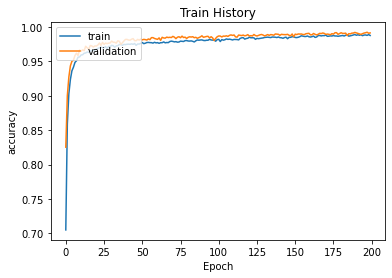

In [31]:
show_train_history(train_history,'accuracy','val_accuracy')

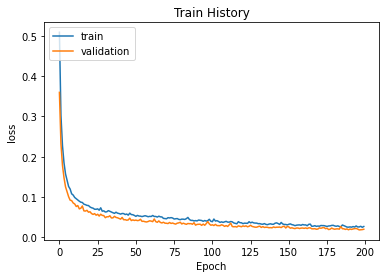

In [32]:
show_train_history(train_history,'loss','val_loss')

In [33]:
scores = cnn.evaluate(X_test, y_test)  
print()  
print("\t[Info] Accuracy of testing data = {:2.1f}%".format(scores[1]*100.0))

649/649 [==============================] - 2s 3ms/step - loss: 0.0199 - accuracy: 0.9911

	[Info] Accuracy of testing data = 99.1%
